# CONTEXTO

En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


https://drive.google.com/file/d/1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ/view?usp=drive_link


El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

* buildings
* forest
* glacier
* mountain
* sea
* street

Las imágenes están divididas en tres conjuntos:

**Train:** Alrededor de 14,000 imágenes para entrenamiento.

**Test:** Alrededor de 3,000 imágenes para evaluación del modelo.

**Prediction:** Alrededor de 7,000 imágenes para predicción final.

# Preparación del Entorno


## Importar Librerias

In [ ]:
!pip install gdown --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gdown
import zipfile
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from keras.layers import Input, Concatenate, Flatten, BatchNormalization, Add, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping




Configurar para que TensorFlow utilice la GPU por defecto

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


Descarga del Dataset

In [ ]:
url = 'https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'  # formato directo de Drive
output = 'dataset_scenes.zip'  # nombre del archivo local
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=76dd14c0-7fd3-4f3d-aeac-c53240330e54
To: /content/dataset_scenes.zip
100%|██████████| 363M/363M [00:09<00:00, 39.4MB/s]


'dataset_scenes.zip'

In [ ]:
with zipfile.ZipFile('dataset_scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_scenes')

In [ ]:
base_dir = 'dataset_scenes'
# Mostrar carpetas principales
print(os.listdir(base_dir))

['seg_test', 'seg_pred', 'seg_train']


In [ ]:
train_dir = os.path.join(base_dir, 'seg_train', 'seg_train')
test_dir = os.path.join(base_dir, 'seg_test', 'seg_test')
pred_dir = os.path.join(base_dir, 'seg_pred', 'seg_pred')

for folder in [train_dir, test_dir, pred_dir]:
    if os.path.exists(folder):
        print(f"\nContenido de {folder}:")
        print(os.listdir(folder))
    else:
        print(f"No se encontró la carpeta: {folder}")



Contenido de dataset_scenes/seg_train/seg_train:
['buildings', 'forest', 'street', 'mountain', 'glacier', 'sea']

Contenido de dataset_scenes/seg_test/seg_test:
['buildings', 'forest', 'street', 'mountain', 'glacier', 'sea']

Contenido de dataset_scenes/seg_pred/seg_pred:
['17437.jpg', '3179.jpg', '4331.jpg', '4733.jpg', '7055.jpg', '4769.jpg', '3754.jpg', '11109.jpg', '6529.jpg', '13433.jpg', '1348.jpg', '17340.jpg', '22297.jpg', '4843.jpg', '3478.jpg', '8150.jpg', '18859.jpg', '2352.jpg', '13870.jpg', '8443.jpg', '4756.jpg', '15066.jpg', '12612.jpg', '12180.jpg', '1277.jpg', '8184.jpg', '5466.jpg', '22698.jpg', '2401.jpg', '274.jpg', '4911.jpg', '19943.jpg', '11756.jpg', '16900.jpg', '12911.jpg', '23614.jpg', '19346.jpg', '23787.jpg', '2482.jpg', '7266.jpg', '12847.jpg', '21523.jpg', '14539.jpg', '11488.jpg', '6861.jpg', '18141.jpg', '16327.jpg', '3962.jpg', '17778.jpg', '19246.jpg', '18352.jpg', '2034.jpg', '10682.jpg', '20471.jpg', '13541.jpg', '7029.jpg', '19181.jpg', '13670.jpg'

Establecemos las direcciones de train, test y del conjunto a predecir.

In [ ]:
train_dir = 'dataset_scenes/seg_train/seg_train'
test_dir = 'dataset_scenes/seg_test/seg_test'
pred_dir = 'dataset_scenes/seg_pred/seg_pred'


Data augmentation para el conjunto de entrenamiento.

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255,           # Normaliza los píxeles de 0-255 a 0-1
  rotation_range=20,        # Rotación aleatoria de la imagen hasta 20 grados
  width_shift_range=0.2,    # Desplazamiento horizontal aleatorio hasta 20% del ancho
  height_shift_range=0.2,   # Desplazamiento vertical aleatorio hasta 20% de la altura
  shear_range=0.2,          # Aplica cizallamiento (shear) aleatorio
  zoom_range=0.2,           # Zoom aleatorio hasta 20%
  horizontal_flip=True,     # Voltea horizontalmente la imagen aleatoriamente
  fill_mode='nearest'       # Cómo rellenar los píxeles vacíos después de transformaciones
)

Para los datos de prueba sólo normalizamos los píxeles.

In [ ]:
# Solo normalización para prueba
test_datagen = ImageDataGenerator(rescale=1./255)

Creamos un generador de datos para el conjunto de entrenamiento.

In [ ]:
train_generator = train_datagen.flow_from_directory(
  train_dir,                # Carpeta de entrenamiento.  Keras lee automáticamente las subcarpetas como clases y devuelve las imágenes etiquetadas.
  target_size=(150, 150),   # Redimensiona todas las imágenes a 150x150 píxeles
  batch_size=32,            # Número de imágenes que se cargan por batch
  class_mode='categorical'  # Las etiquetas se codifican en one-hot (6 clases)
)


Found 14034 images belonging to 6 classes.


Creamos un generador de datos para los datos de prueba.

In [ ]:
test_generator = test_datagen.flow_from_directory(
  test_dir,                 # Carpeta de prueba
  target_size=(150, 150),   # Redimensiona a 150x150
  batch_size=16,            # Tamaño del batch
  class_mode='categorical',  # Codificación one-hot
  shuffle=False             # No barajamos los datos de prueba
)


Found 3000 images belonging to 6 classes.


In [ ]:
# Verificar clases y cantidad de imágenes
print("Clases detectadas:", train_generator.class_indices)

print("Número de imágenes de entrenamiento:", train_generator.samples)
print("Número de imágenes de prueba:", test_generator.samples)


Clases detectadas: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Número de imágenes de entrenamiento: 14034
Número de imágenes de prueba: 3000


Distribución de clases en el conjunto de entrenamiento:
buildings: 2191 imágenes
forest: 2271 imágenes
glacier: 2404 imágenes
mountain: 2512 imágenes
sea: 2274 imágenes
street: 2382 imágenes


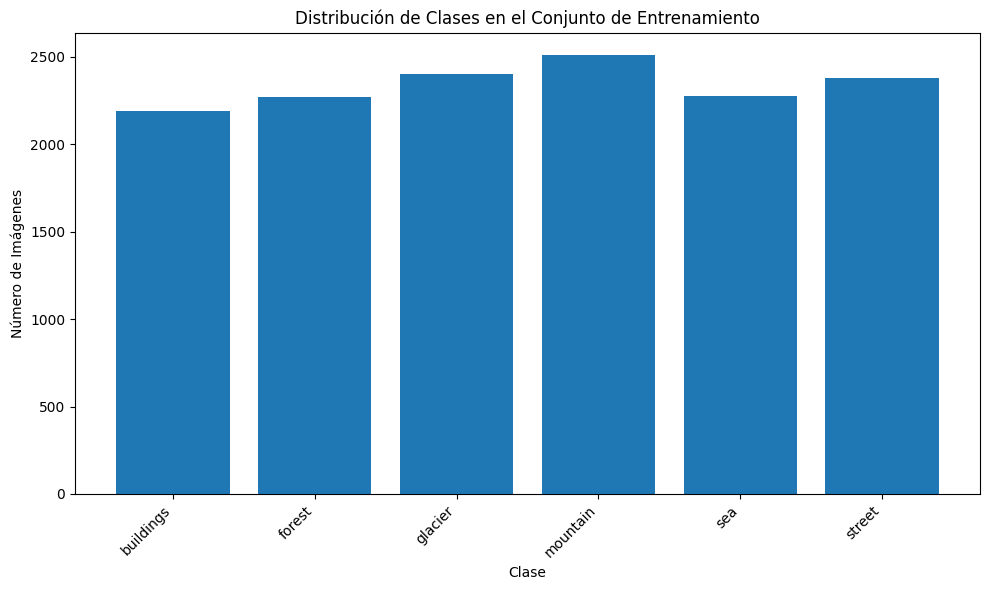

In [ ]:
# Verificar que las clases estan balanceadas
class_indices = train_generator.class_indices
# Obtener las etiquetas de clase para cada imagen
labels = train_generator.labels
# Contar cuántas imágenes hay por cada clase
class_counts = np.bincount(labels)

print("Distribución de clases en el conjunto de entrenamiento:")
for class_name, class_index in class_indices.items():
    print(f"{class_name}: {class_counts[class_index]} imágenes")

plt.figure(figsize=(10, 6))
plt.bar(class_indices.keys(), class_counts)
plt.xlabel("Clase")
plt.ylabel("Número de Imágenes")
plt.title("Distribución de Clases en el Conjunto de Entrenamiento")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Observamos que el desbalance es leve.



Visualizamos algunas de las imagenes generadas en el conjunto de entrenamiento.

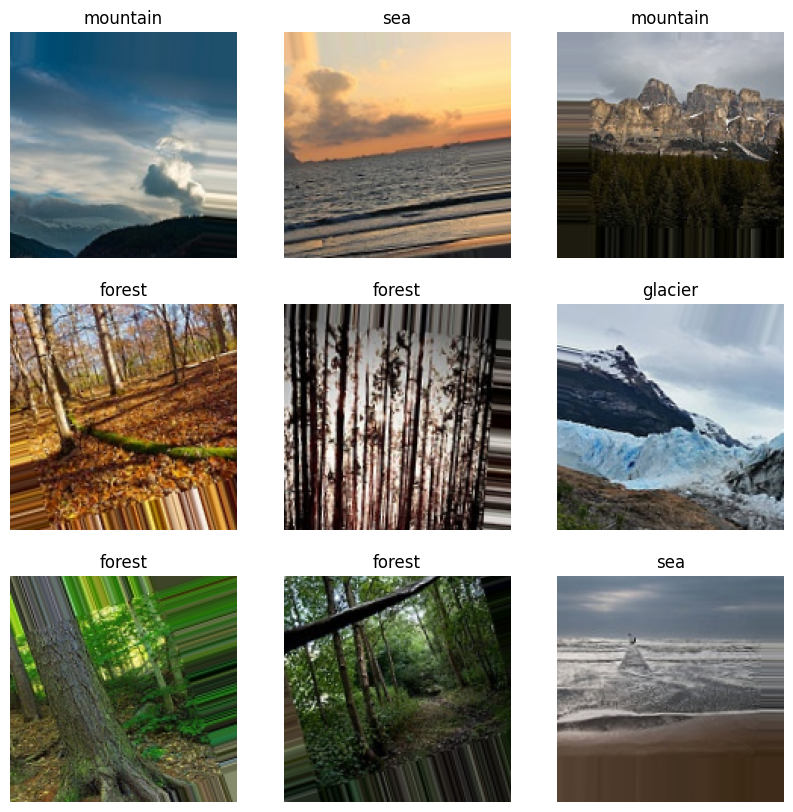

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
  for i in range(min(len(images), 9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_idx = list(labels[i]).index(1)
    plt.title(list(train_generator.class_indices.keys())[class_idx])
    plt.axis("off")
  break

# Modelo con Capas Densas


Definimos y compilamos el modelo secuencial de capas densas.

In [ ]:
model_dense = Sequential([
    Input(shape=(150, 150, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [ ]:
model_dense.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#Resumen del modelo
model_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,322,342 (16.49 MB)

 Trainable params: 4,322,342 (16.49 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo.

In [ ]:
# Train the model
history_dense = model_dense.fit(train_generator, epochs=10, validation_data=test_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 89s 194ms/step - accuracy: 0.1742 - loss: 3.1553 - val_accuracy: 0.1750 - val_loss: 1.7906
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 179ms/step - accuracy: 0.1782 - loss: 1.8094 - val_accuracy: 0.1750 - val_loss: 1.7902
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 80s 182ms/step - accuracy: 0.1801 - loss: 1.7908 - val_accuracy: 0.1750 - val_loss: 1.7901
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - accuracy: 0.1763 - loss: 1.7914 - val_accuracy: 0.1750 - val_loss: 1.7901
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.1773 - loss: 1.7908 - val_accuracy: 0.1750 - val_loss: 1.7902
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.1775 - loss: 1.7915 - val_accuracy: 0.1750 - val_loss: 1.7900
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 80s 182ms/step - accuracy: 0.1801 - loss: 1.7909 - val_accuracy: 0.1750 - val_loss: 1.7901
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.1757 - loss: 1

Visualizamos la exactitud (accuracy) y la función de pérdida para los datos de entrenamiento y validación.

In [ ]:
# Evaluación en el conjunto de test
test_loss_dense, test_acc_dense = model_dense.evaluate(test_generator, verbose=1)
print(f"Test Accuracy Dense: {test_acc_dense:.4f}")
print(f"Test Loss Dense: {test_loss_dense:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0984 - loss: 1.8135
Test Accuracy Dense: 0.1750
Test Loss Dense: 1.7902


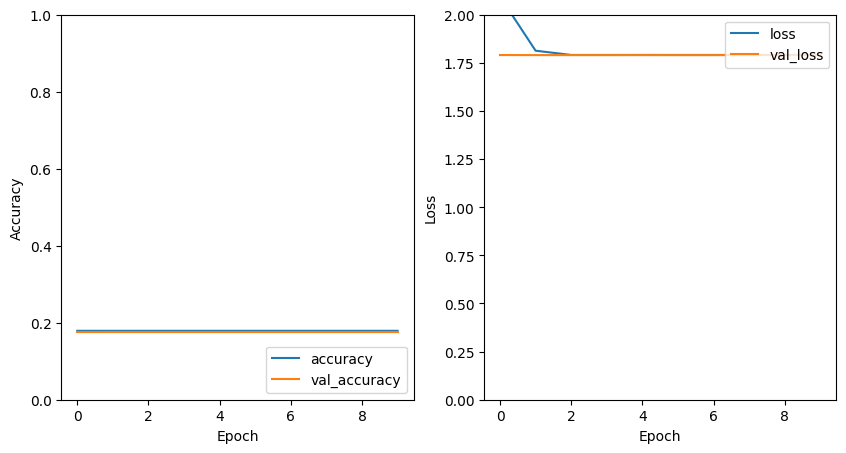

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dense.history['accuracy'], label='accuracy')
plt.plot(history_dense.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_dense.history['loss'], label='loss')
plt.plot(history_dense.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

El modelo logra una exactitud (accuracy) de 0.1750 para los datos de test. No tiene una buena generalización y se puede observar que el modelo no aprende con el paso de las épocas.

# Modelo con Capas Convolucionales y Densas

Definimos y compilamos el modelo con capas convolucionales y densas.

In [ ]:
model_cnn= models.Sequential([
    Input(shape=(150, 150, 3)),
    # Primera capa convolucional: 32 filtros 3x3, activación ReLU
    layers.Conv2D(32, (3,3), activation='relu'),

    # Capa de pooling: reduce la dimensionalidad a la mitad
    layers.MaxPooling2D(2,2),

    # Segunda capa convolucional: 64 filtros 3x3
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Tercera capa convolucional: 128 filtros 3x3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Aplanamos la salida 3D a 1D para conectarla con capas densas
    layers.Flatten(),

    # Capa densa con 128 neuronas y activación ReLU
    layers.Dense(64, activation='relu'),

    # Dropout: descarta aleatoriamente 50% de neuronas durante entrenamiento para evitar overfitting
    layers.Dropout(0.2),

    # Capa de salida: 6 neuronas (una por clase), activación softmax para clasificación multi-clase
    layers.Dense(6, activation='softmax')
])

In [ ]:
model_cnn.compile(
    optimizer='adam',                 # Optimizer: algoritmo para actualizar los pesos durante el entrenamiento
    loss='categorical_crossentropy',  # Función de pérdida para clasificación multi-clase (6 clases)
    metrics=['accuracy']              # Métrica para evaluar rendimiento: exactitud
)


In [ ]:
#Resumen del modelo
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,461,190 (9.39 MB)

 Trainable params: 2,461,190 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = model_cnn.fit(
    train_generator,       # Generador de entrenamiento que entrega batches de imágenes + etiquetas
    validation_data=test_generator,  # Generador de prueba para calcular la pérdida y exactitud en cada época
    epochs=15              # Número de veces que el modelo recorrerá todo el conjunto de entrenamiento
)


Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 203ms/step - accuracy: 0.4251 - loss: 1.4039 - val_accuracy: 0.6913 - val_loss: 0.8501
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 195ms/step - accuracy: 0.6466 - loss: 0.9210 - val_accuracy: 0.6760 - val_loss: 0.8748
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 88s 201ms/step - accuracy: 0.7050 - loss: 0.8121 - val_accuracy: 0.7960 - val_loss: 0.5930
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 196ms/step - accuracy: 0.7252 - loss: 0.7464 - val_accuracy: 0.7907 - val_loss: 0.6112
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 87s 198ms/step - accuracy: 0.7468 - loss: 0.6987 - val_accuracy: 0.7970 - val_loss: 0.5644
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 87s 199ms/step - accuracy: 0.7683 - loss: 0.6401 - val_accuracy: 0.8130 - val_loss: 0.5148
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 195ms/step - accuracy: 0.7795 - loss: 0.6199 - val_accuracy: 0.8030 - val_loss: 0.5788
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 85s 194ms/step - accuracy: 0.7789 - loss: 0

Visualizamos la precisión (accuracy) y la función de pérdida para los datos de entrenamiento y validación.

In [ ]:
# Evaluación en el conjunto de test
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_generator, verbose=1)
print(f"Test Accuracy CNN: {test_acc_cnn:.4f}")
print(f"Test Loss CNN: {test_loss_cnn:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8495 - loss: 0.4097
Test Accuracy CNN: 0.8483
Test Loss CNN: 0.4183


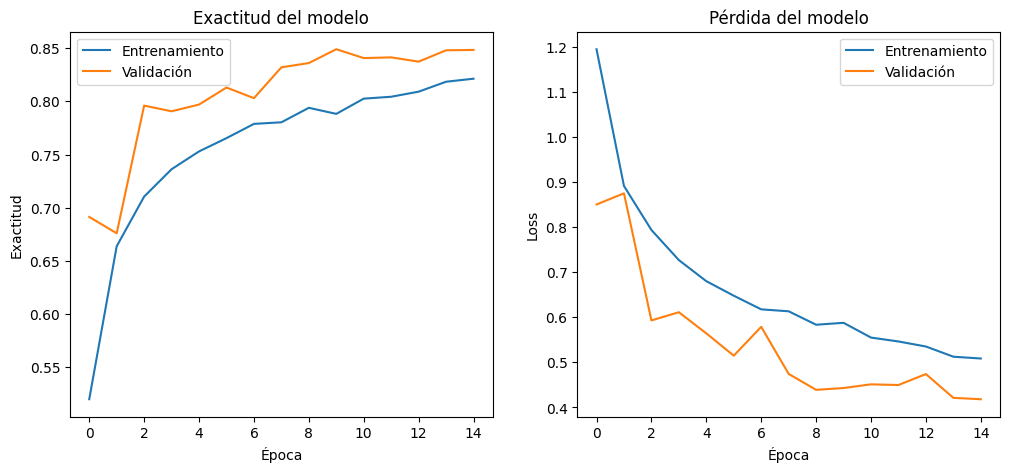

In [ ]:
plt.figure(figsize=(12,5))

# Exactitud
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Entrenamiento')
plt.plot(history_cnn.history['val_accuracy'], label='Validación')
plt.title('Exactitud del modelo')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Entrenamiento')
plt.plot(history_cnn.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


El modelo logra un accuracy de 0.8483 para los datos de test y
no se observan signos de overfitting.

# Modelo con Bloque Residual de Identidad


Definimos y compilamos el modelo ResNet.

In [ ]:
def resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = resnet_module(x, 64, strides=2)
    x = resnet_module(x, 64)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

def resnet_model(input_shape, num_classes):
  inputs = Input(shape=input_shape)

  #x = Rescaling(1./255)(inputs) no aplica ya que vienen normalizados desde el generator

  x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(inputs)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  x = resnet_module(x, 64, strides=2)
  x = resnet_module(x, 64)

  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
input_shape = (150, 150, 3)
num_classes = 6
model_resnet = resnet_model(input_shape, num_classes)

In [ ]:
model_resnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_resnet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 75, 75,    │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 38, 38,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 19, 19,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 19, 19,    │     36,928 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 19, 19,    │      2,112 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 19, 19,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 19, 19,    │     36,928 │ activation_5[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 19, 19,    │     36,928 │ activation_6[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_14[0][0] 

 Total params: 6,049,990 (23.08 MB)

 Trainable params: 6,049,350 (23.08 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
epochs = 10

history_resnet = model_resnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs
)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 92s 196ms/step - accuracy: 0.4845 - loss: 3.6520 - val_accuracy: 0.6413 - val_loss: 0.9418
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 185ms/step - accuracy: 0.6673 - loss: 0.8772 - val_accuracy: 0.4457 - val_loss: 2.1214
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.7322 - loss: 0.7444 - val_accuracy: 0.7080 - val_loss: 0.8239
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.7465 - loss: 0.6775 - val_accuracy: 0.6953 - val_loss: 0.8413
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.7745 - loss: 0.6283 - val_accuracy: 0.7547 - val_loss: 0.7257
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 80s 183ms/step - accuracy: 0.7849 - loss: 0.6026 - val_accuracy: 0.6473 - val_loss: 1.0770
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 80s 183ms/step - accuracy: 0.7964 - loss: 0.5627 - val_accuracy: 0.5750 - val_loss: 1.4467
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.8049 - loss: 0

Visualizamos la exactitud (accuracy) y la función de pérdida para los datos de entrenamiento y validación.

In [ ]:
# Evaluación en el conjunto de test
test_loss_res, test_acc_res = model_resnet.evaluate(test_generator, verbose=1)
print(f"Test Accuracy ResNet: {test_acc_res:.4f}")
print(f"Test Loss ResNet: {test_loss_res:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7968 - loss: 0.5527
Test Accuracy ResNet: 0.7750
Test Loss ResNet: 0.6221


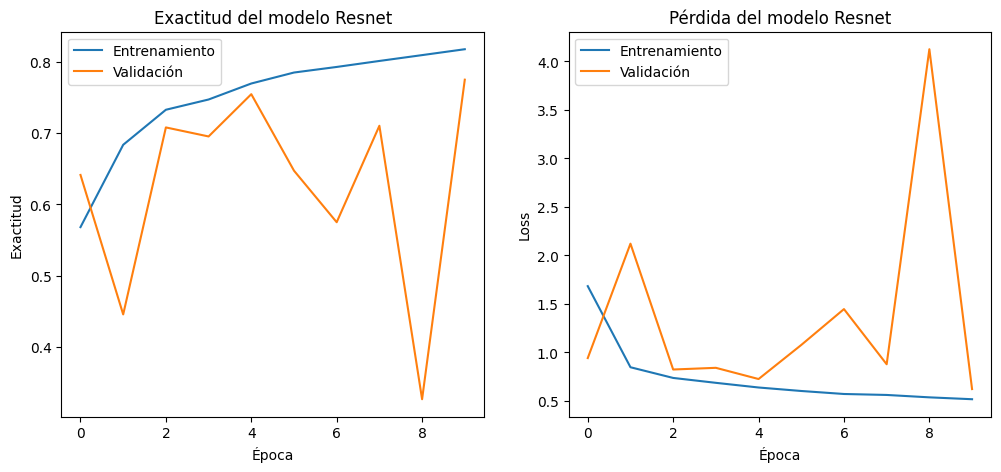

In [ ]:
plt.figure(figsize=(12,5))

# Exactitud
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='Entrenamiento')
plt.plot(history_resnet.history['val_accuracy'], label='Validación')
plt.title('Exactitud del modelo Resnet')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='Entrenamiento')
plt.plot(history_resnet.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo Resnet')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


El modelo logra una exactitud (accuracy) de 0.7750 en los datos de test.
Se observa un comportamiento muy caótico en la curva de validación lo que podría significar que el modelo se ajusta mucho a los datos de entrenamiento.

# Modelo Transfer Learning


Data Augmentation para TransferLearning.

In [ ]:
train_datagen_tl = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)
test_datagen_tl = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_tl = train_datagen_tl.flow_from_directory(
  train_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)
test_generator_tl = test_datagen_tl.flow_from_directory(
  test_dir, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False

)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Definimos la arquitectura de la red.

In [ ]:
def build_model(input_shape, num_classes):
  base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                              include_top=False,
                                              weights='imagenet')
  base_model.trainable = False

  i = Input(shape=input_shape)
  x = base_model(i, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(i, x)

Construimos y visualizamos el resumen del modelo.

In [ ]:
print("Building model")
num_classes = 6
input_shape = (224,224,3)

model_tl = build_model(input_shape, num_classes=num_classes)

model_tl.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

model_tl.summary()

Building model
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,049 (16.70 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Entrenamos el modelo.

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=0, mode="min")
checkpoint_acc = ModelCheckpoint(
    '/content/drive/MyDrive/TP3_Modelos/best_model_tl.keras',
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min"
)

In [ ]:
print("Entrenando EfficientNetB0 (fase 1: capas congeladas)")
history_tl = model_tl.fit(train_generator_tl, validation_data=test_generator_tl, epochs=5, callbacks=[checkpoint_acc, reduce_lr, early_stopping])

# Fine-tuning
base_model = model_tl.layers[1]
base_model.trainable = True
for layer in base_model.layers[:-20]:
  layer.trainable = False

model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy']) #Disminuyo el learning rate del optimizador
print("Entrenando EfficientNetB0 (fase 2: fine-tuning)")
history_tl_fine = model_tl.fit(train_generator_tl, validation_data=test_generator_tl, epochs=10, callbacks=[checkpoint_acc, reduce_lr, early_stopping])

Entrenando EfficientNetB0 (fase 1: capas congeladas)
Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8343 - loss: 0.4450
Epoch 1: val_accuracy improved from -inf to 0.91667, saving model to /content/drive/MyDrive/TP3_Modelos/best_model_tl.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 224s 451ms/step - accuracy: 0.8344 - loss: 0.4448 - val_accuracy: 0.9167 - val_loss: 0.2194 - learning_rate: 0.0010
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9082 - loss: 0.2479
Epoch 2: val_accuracy improved from 0.91667 to 0.92067, saving model to /content/drive/MyDrive/TP3_Modelos/best_model_tl.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 162s 368ms/step - accuracy: 0.9082 - loss: 0.2479 - val_accuracy: 0.9207 - val_loss: 0.2056 - learning_rate: 0.0010
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9145 - loss: 0.2326
Epoch 3: val_accuracy improved from 0.92067 to 0.92833, saving model to /content/drive/MyDrive/TP3_Modelos/best_model_tl.keras
439/439 ━━━━━━━━━━

Visualizamos la exactitud (accuracy) y función de pérdida para los datos de entrenamiento y validación.

In [ ]:
# Evaluación en el conjunto de test
test_loss_tl, test_acc_tl = model_tl.evaluate(test_generator_tl, verbose=1)
print(f"Test Accuracy TL: {test_acc_tl:.4f}")
print(f"Test Loss TL: {test_loss_tl:.4f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9313 - loss: 0.1977
Test Accuracy TL: 0.9257
Test Loss TL: 0.2113


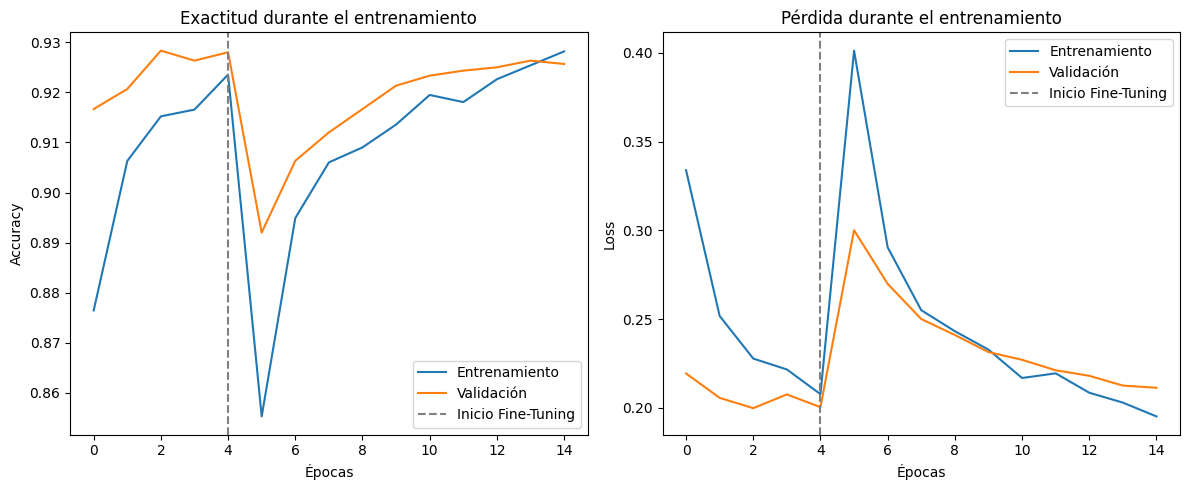

In [ ]:
# Unir los historiales de ambas fases
acc = history_tl.history['accuracy'] + history_tl_fine.history['accuracy']
val_acc = history_tl.history['val_accuracy'] + history_tl_fine.history['val_accuracy']
loss = history_tl.history['loss'] + history_tl_fine.history['loss']
val_loss = history_tl.history['val_loss'] + history_tl_fine.history['val_loss']

# Curvas de exactitud y pérdida
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(acc, label='Entrenamiento')
plt.plot(val_acc, label='Validación')
plt.axvline(x=len(history_tl.history['accuracy'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.axvline(x=len(history_tl.history['loss'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


El modelo logra una alta exactitud en el conjunto de test con un accuracy de 0.9257.
Además, el fine-tuning contribuyó positivamente a mejorar el rendimiento general del modelo.

# Comparacion de modelos

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


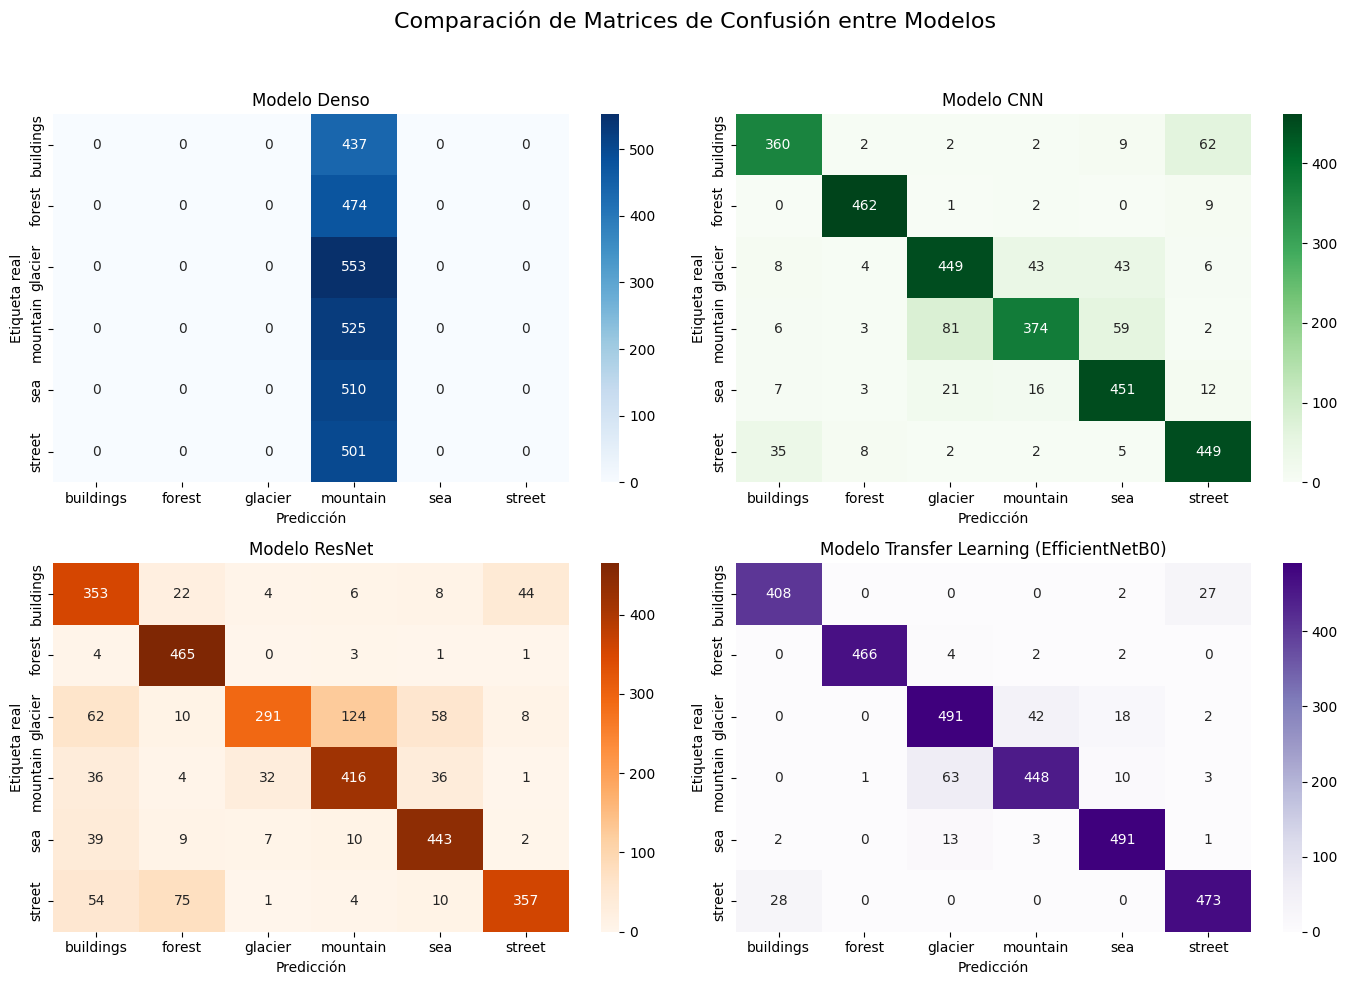

In [ ]:
# Función para obtener predicciones y matriz de confusión
def get_confusion_matrix_and_report(model, generator, model_name):
    # Predicciones del modelo
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)

    # Matriz de confusión
    cm = confusion_matrix(generator.classes, y_pred)
    labels = list(generator.class_indices.keys())

    # Reporte de clasificación
    #print(f"\nReporte de clasificación para {model_name}")
    #print(classification_report(generator.classes, y_pred, target_names=labels))

    return cm, labels

# Obtener matrices de confusión
cm_dense, labels = get_confusion_matrix_and_report(model_dense, test_generator, "Modelo Denso")
cm_cnn, _ = get_confusion_matrix_and_report(model_cnn, test_generator, "Modelo CNN")
cm_resnet, _ = get_confusion_matrix_and_report(model_resnet, test_generator, "Modelo ResNet")
cm_tl, labels_tl = get_confusion_matrix_and_report(model_tl, test_generator_tl, "Modelo Transfer Learning (EfficientNetB0)")

# Gráfico comparativo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación de Matrices de Confusión entre Modelos', fontsize=16)

sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=labels, yticklabels=labels)
axes[0,0].set_title('Modelo Denso')

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=axes[0,1],
            xticklabels=labels, yticklabels=labels)
axes[0,1].set_title('Modelo CNN')

sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Oranges', ax=axes[1,0],
            xticklabels=labels, yticklabels=labels)
axes[1,0].set_title('Modelo ResNet')

sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Purples', ax=axes[1,1],
            xticklabels=labels_tl, yticklabels=labels_tl)
axes[1,1].set_title('Modelo Transfer Learning (EfficientNetB0)')

for ax in axes.flat:
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Etiqueta real')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# Resultados
results = {
    "Modelo": ["Dense", "CNN", "ResNet", "Transfer Learning"],
    "Accuracy": [test_acc_dense, test_acc_cnn, test_acc_res, test_acc_tl]}
# Convertir en DataFrame
df_results = pd.DataFrame(results)
print(df_results)


              Modelo  Accuracy      Loss
0              Dense  0.175000  1.790207
1                CNN  0.848333  0.418301
2             ResNet  0.459667  2.001502
3  Transfer Learning  0.925667  0.211308


##Conclusión

* **Modelo Denso:** El accuracy bajo del modelo se debe a que predice una única clase (mountain) en todos los casos.

* **Modelo CNN:** Tiene un buen equilibrio entre clases con algunos errores en clases similares. El modelo aprendió patrones útiles y logra un buen desempeño general.

* **Modelo ResNet:** El modelo si bien tiene un accuracy relativamente bueno, confunde algunas clases y comete bastantes errores cuando predice buildings.

* **Modelo Transfer Learning:** Muy buena clasificación en todas las clases con pocas confusiones. Es el modelo que logra mejores resultados en todos los aspectos.




#Prediccion con modelo de Transfer Learning

Procedemos a realizar algunas predicciones con el modelo de transfer learning.

In [ ]:
# Predicciones sobre el conjunto de test
predictions = model_tl.predict(test_generator_tl, verbose=1)

# Convertir de probabilidades a clases
y_pred = np.argmax(predictions, axis=1)


188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


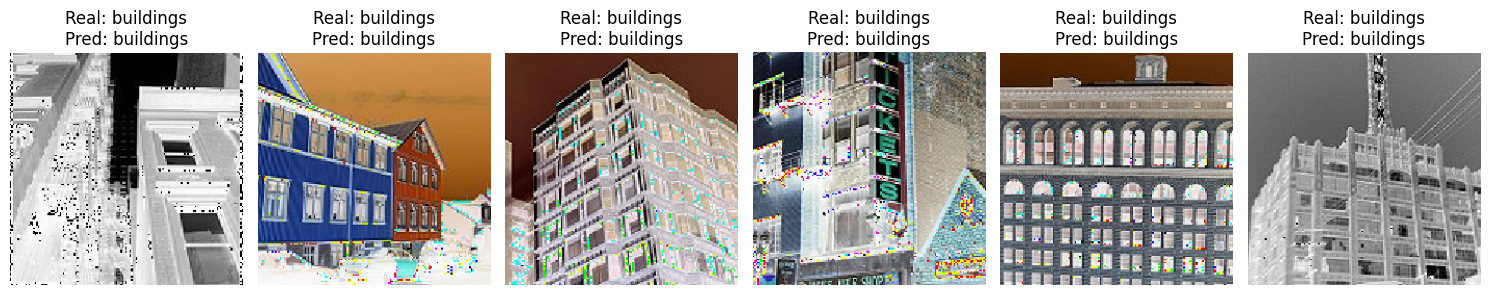

In [ ]:
# Obtener un batch del conjunto de test
x_batch, y_batch = next(test_generator_tl)

# Asegurarnos de que el batch tenga al menos 6 imágenes
num_images = min(6, len(x_batch))

# Obtener nombres de clases
class_names = list(test_generator_tl.class_indices.keys())

# Crear una figura para mostrar 6 imágenes
plt.figure(figsize=(15, 5))

for i in range(num_images):
    img = x_batch[i]
    true_label = np.argmax(y_batch[i])

    # Hacer la predicción
    pred = model_tl.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label = np.argmax(pred)

    # Subplot para cada imagen
    plt.subplot(1, num_images, i+1)
    plt.imshow((img * 255).astype("uint8"))
    plt.axis('off')
    plt.title(f"Real: {class_names[true_label]}\nPred: {class_names[pred_label]}")

plt.tight_layout()
plt.show()


Observamos que el modelo realiza de manera correcta las predicciones analizadas a modo de ejemplo.